# CIFAR10 classification using CNN codes

Here we are going to build linear models to classify CNN codes of CIFAR10 images.

We assume that we already have all the codes extracted by the scripts in the following notebooks:
- [Feature_extraction_using_keras.ipynb](Feature_extraction_using_keras.ipynb)
- [Feature_extraction_using_Inception_v3.ipynb](Feature_extraction_using_Inception_v3.ipynb)

In [1]:
!ls features/

CIFAR10_Inception_v3_features.npz    CIFAR10_vgg16-keras_features.npz
CIFAR10_incv3-keras_features.npz     CIFAR10_vgg19-keras_features.npz
CIFAR10_resnet50-keras_features.npz


## Load CNN codes

In [2]:
model_names = [
    'vgg16-keras', 
    'vgg19-keras', 
    'resnet50-keras',
    'incv3-keras',   
    'Inception_v3'
]

import numpy as np

data = dict()
for model_name in model_names:
    data[model_name] = np.load('features/CIFAR10_{model}_features.npz'.format(model=model_name)) 

In [3]:
# It is important that CNN codes for all the models are given in the same order,
# i.e. they refer to the same samples from the dataset (both training and testing)

y_training = data[ model_names[0] ]['labels_training'] # this should be common for all the models
y_testing  = data[ model_names[0] ]['labels_testing']  # this should be common for all the models

for i in range(1,len(model_names)):
    assert( (data[model_names[i]]['labels_training'] == y_training).all() )
    assert( (data[model_names[i]]['labels_testing'] == y_testing).all() )

## LinearSVC classifier from scikit-learn

We used the linear classifier from the [scikit-learn](http://scikit-learn.org) library.<br/>
More precisely, we used [`LinearSVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

In [5]:
# First we tried all of the following parameters for each model
model_params = {
    'vgg16-keras':    [ {'C':0.0001}, {'C':0.001}, {'C':0.01,'max_iter':3000},
                        {'C':0.1}, {'C':0.5}, {'C':1.0}, {'C':1.2}, {'C':1.5}, {'C':2.0}, {'C':10.0} ],
    'vgg19-keras':    [ {'C':0.0001}, {'C':0.001}, {'C':0.01},
                        {'C':0.1}, {'C':0.5}, {'C':1.0}, {'C':1.2}, {'C':1.5}, {'C':2.0}, {'C':10.0} ],
    'resnet50-keras': [ {'C':0.0001}, {'C':0.001}, {'C':0.01},
                        {'C':0.1}, {'C':0.5}, {'C':1.0}, {'C':1.2}, {'C':1.5}, {'C':2.0}, {'C':10.0} ],
    'Inception_v3':   [ {'C':0.0001}, {'C':0.001}, {'C':0.01},
                        {'C':0.1}, {'C':0.5}, {'C':1.0}, {'C':1.2}, {'C':1.5}, {'C':2.0}, {'C':10.0} ],
    'incv3-keras':    [ {'C':0.0001}, {'C':0.001}, {'C':0.01},
                        {'C':0.1}, {'C':0.5}, {'C':1.0}, {'C':1.2}, {'C':1.5}, {'C':2.0}, {'C':10.0} ],
}

# and we decided to choose
model_params = {
    'vgg16-keras':    [ {'C':0.0001} ],
    'vgg19-keras':    [ {'C':0.001}  ],
    'resnet50-keras': [ {'C':0.01}   ],
    'Inception_v3':   [ {'C':0.01}   ],
    'incv3-keras':    [ {'C':0.001}  ]
}

In [6]:
from sklearn.svm import LinearSVC

# C - chosen experimentally (see explanation below)
results = dict()

for model_name in model_params:
    print('model = ', model_name)
    X_training = data[model_name]['features_training']
    X_testing = data[model_name]['features_testing']
    print( 'X_training size = {}'.format(X_training.shape))
#     print( 'X_testing size = {}'.format(X_testing.shape))
#     print( 'y_training size = {}'.format(y_training.shape))
#     print( 'y_testing size = {}'.format(y_testing.shape))
    results[model_name] = []
    for params in model_params[model_name]:
        clf = LinearSVC(**params, verbose=1)
        clf.fit( X_training, y_training )
        y_pred = clf.predict( X_testing )
        score = sum( y_pred == y_testing )
        print('features={:>16}, C={:8f} => score={:5d}'.format(model_name,params['C'],score))
        results[model_name].append({'pred': y_pred, 'score': score, 'clf': clf})

model =  incv3-keras
X_training size = (50000, 2048)
[LibLinear]features=     incv3-keras, C=0.001000 => score= 7577
model =  vgg16-keras
X_training size = (50000, 512)
[LibLinear]features=     vgg16-keras, C=0.000100 => score= 8515
model =  vgg19-keras
X_training size = (50000, 512)
[LibLinear]features=     vgg19-keras, C=0.001000 => score= 8654
model =  Inception_v3
X_training size = (50000, 2048)
[LibLinear]features=    Inception_v3, C=0.010000 => score= 9061
model =  resnet50-keras
X_training size = (50000, 2048)
[LibLinear]features=  resnet50-keras, C=0.010000 => score= 9130


We tried to build LinearSVC classifier with many possible paramater C.
Below we present the accuracy of all the considered models.

                                           Model 
             -----------------------------------------------------------------------------
       C     | vgg16-keras | vgg19-keras | resnet50-keras | incv3-keras | Inception_v3
    ------------------------------------------------------------------------------------
     0.0001  |     8515    |     8633    |     9043       |    7244     |    8860
     0.001   |     8528    |     8654    |     9158       |    7577     |    9005
     0.01    |     8521    |     8644    |     9130       |    7604     |    9061
     0.1     |     8464    |     8615    |     8897       |    7461     |    8959
     0.5     |     8233    |     8014    |     8856       |    7409     |    8834
     1.0     |     8278    |     8225    |     8858       |             |    8776
     1.2     |     8083    |             |     8861       |             |    8772
     1.5     |     7909    |             |     8849       |             |    8762
    10.0     |             |             |     8860       |             |    8709

In [7]:
from sklearn.externals import joblib

for model_name in model_params:
    joblib.dump(results[model_name][0]['clf'], \
                'classifiers/{score}-{name}.pkl'.format(score=results[model_name][0]['score'], name=model_name))

In [28]:
!ls -l classifiers/*.pkl

-rw-r--r-- 1 rno rno 164764 sie 29 19:15 classifiers/7577-incv3-keras.pkl
-rw-r--r-- 1 rno rno  41884 sie 29 19:15 classifiers/8515-vgg16-keras.pkl
-rw-r--r-- 1 rno rno  41884 sie 29 19:15 classifiers/8654-vgg19-keras.pkl
-rw-r--r-- 1 rno rno 164764 sie 29 19:15 classifiers/9061-Inception_v3.pkl
-rw-r--r-- 1 rno rno 164764 sie 29 19:15 classifiers/9130-resnet50-keras.pkl


In [22]:
best_model = 'resnet50-keras'
X_training = data[best_model]['features_training']
X_testing  = data[best_model]['features_testing']

clf = results[best_model][0]['clf']
print( 'Best accuracy = {}'.format( clf.score( X_testing, y_testing ) ) )
y_predictions = clf.predict( X_testing )

Best accuracy = 0.913


So we obtained **91.30%** accuracy on testing dataset using LinearSVC classifier on top of features extracted with ResNET50 convolutional neural network.

### Some misclassifications

In [23]:
import myutils
from sklearn.metrics import confusion_matrix
labels = myutils.load_CIFAR_classnames()
conf_matrix = confusion_matrix( y_testing, y_predictions )

print( 'Confusion matrix:\n', conf_matrix )
print( labels )

Confusion matrix:
 [[923   4  12   4   6   2   2   7  33   7]
 [  5 950   1   1   1   0   4   3   7  28]
 [ 16   0 889  27  29   8  18   7   4   2]
 [  5   4  23 824  26  71  25  10   6   6]
 [  6   0  17  12 911  11  17  22   1   3]
 [  0   0  14  75  17 872   7  12   3   0]
 [  5   1  14  19   5   2 953   0   1   0]
 [  5   1   5   9  27  18   1 934   0   0]
 [ 26   5   4   1   1   1   0   2 953   7]
 [ 15  44   1   4   0   1   2   2  10 921]]
['plane', 'auto', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [24]:
i,j = 3,0
img_idx = [ k for k in range(10000) if y_testing[k]==i and y_predictions[k]==j ]  
print( 'We have, e.g., {c} {iname}s predicted to be {jname}'.format(\
       c=conf_matrix[i,j], iname=labels[i], jname=labels[j]) )
# print(img_idx)

We have, e.g., 5 cats predicted to be plane


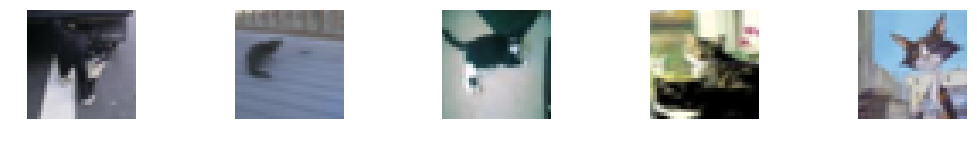

In [25]:
_, data_testing = myutils.load_CIFAR_dataset(shuffle=False)
from matplotlib import pyplot as plt
%matplotlib inline 

fig = plt.figure(figsize=(18,2));
for _i in range(conf_matrix[i,j]):
    a=fig.add_subplot(1,conf_matrix[i,j],_i+1)
    plt.imshow(data_testing[img_idx[_i]][0])
    plt.axis('off')

### Saving parameters
We simply save the matrix with weights and bias vector for linear classifier.

In [26]:
# np.savez_compressed("classifiers/9130_resnet50-keras_LinearSVC.npz",W=np.array(clf.coef_).T, b=clf.intercept_)

## k-nearest neighbors classifier

Let us note that simple [kNN classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
(with k=10), trained with 5000 training features (CNN codes from Inception_v3) gives **83.45%** accuracy on whole 10000 testing images.

Remark that computing predictions with this classifier is very complex and it is not recommended for classificcation of images.

Here is the code to compute the score on testing dataset.
```python
from sklearn.neighbors import KNeighborsClassifier
kNN_clf = KNeighborsClassifier(n_neighbors=10)
kNN_clf.fit(X_training, y_training)
print( 'Classification score = ', kNN_clf.score( X_testing, y_testing ) )
# Classification score =  0.8345
```

## Logistic regression

Finally we used <tt>[Logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)</tt> with default parameters. We trained the model with all the training data and obtained **90.37%** accuracy on testing dataset.

In [27]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_training, y_training)
print( 'Linear regression accuracy = ', clf.score( X_testing, y_testing ) )

Linear regression accuracy =  0.9037
